In [2]:
import os,inspect,sys,re
# folder_name = os.path.dirname(os.path.realpath(__file__))
folder_name = os.path.abspath('/Users/edoardo/Work/Code/GAM_code/fitting')
main_dir = os.path.dirname(folder_name)
sys.path.append(os.path.join(main_dir,'GAM_library'))
sys.path.append(os.path.join(main_dir,'firefly_utils'))
sys.path.append(os.path.join(folder_name,'util_preproc'))

from GAM_library import *
from data_handler import *
from gam_data_handlers import *
import numpy as np
import scipy.stats as sts
from copy import deepcopy
from knots_constructor_Julie import *
from path_class import get_paths_class
from scipy.io import loadmat
from utils_loading import unpack_preproc_data
import dill
from scipy.ndimage import convolve1d
from scipy.interpolate import interp1d

path None do not exist

Module pycuda not found! Use CPU


ModuleNotFoundError: No module named 'knots_constructor_Julie'

In [2]:
# Run this code after the .npz file is transferred into the cluster!!!

In [3]:
# fhName = os.path.join(main_dir, 'npz_files','close','m53s14.npz')
fhName = '/scratch/jpn5/dataset_firefly/m53s91.npz'
if fhName.endswith('.mat'):
    dat = loadmat(fhName)
elif fhName.endswith('.npy'):
    dat = np.load(fhName, allow_pickle=True).all()
elif fhName.endswith('.npz'):
    dat = np.load(fhName, allow_pickle=True)

In [4]:
# with lfp
par_list = ['Xt', 'Yt', 'lfp_beta', 'lfp_alpha', 'lfp_theta', 'var_names', 'info_trial',
        'trial_idx', 'brain_area', 'pre_trial_dur', 'post_trial_dur', 'time_bin', 'cR', 'presence_rate', 
            'isiV',
        'unit_type','channel_id','electrode_id','cluster_id']
(Xt, yt, lfp_beta, lfp_alpha, lfp_theta, var_names, trial_type,
  trial_idx, brain_area, pre_trial_dur, post_trial_dur, time_bin,
  cont_rate_filter, presence_rate_filter, isi_v_filter, unit_type,
  channel_id,electrode_id,cluster_id) = unpack_preproc_data(fhName, par_list)

In [5]:
print(brain_area)
print(pre_trial_dur)

['MST' 'MST' 'MST' 'MST' 'MST' 'MST' 'MST' 'MST' 'MST' 'MST' 'MST' 'MST'
 'MST' 'PFC' 'PFC' 'PFC' 'PFC' 'PFC' 'PFC' 'PFC' 'PFC' 'PFC' 'PPC' 'PPC'
 'PPC' 'PPC' 'PPC' 'PPC' 'PPC' 'PFC' 'PFC' 'PFC' 'PFC' 'PFC' 'PFC' 'PFC'
 'PFC' 'PFC' 'PPC' 'PPC' 'PFC' 'PFC' 'PPC' 'PPC' 'PPC' 'PPC' 'PFC' 'PFC'
 'PFC' 'PFC' 'PFC' 'PFC' 'PFC' 'PPC' 'PPC' 'PPC' 'PPC' 'PPC' 'PFC' 'PFC'
 'PFC' 'PFC' 'PFC' 'PPC' 'PPC' 'PPC' 'PPC' 'PFC']
0.2


In [6]:
print(Xt.shape)
print(var_names)
print(yt.shape)
print(lfp_beta.shape)
print(lfp_alpha.shape)
print(lfp_theta.shape)

(507613, 16)
['rad_vel' 'ang_vel' 'rad_path' 'ang_path' 'rad_target' 'ang_target'
 't_move' 't_flyOFF' 't_stop' 't_reward' 'eye_vert' 'eye_hori' 'hand_vel1'
 'hand_vel2' 'rad_acc' 'ang_acc']
(507613, 68)
(507613, 68)
(507613, 68)
(507613, 68)


In [7]:
dict_xlims = {}

# get the unit to include as input covariates
cont_rate_filter = (cont_rate_filter < 0.2) | (unit_type == 'multiunit')
presence_rate_filter = presence_rate_filter > 0.9
isi_v_filter = isi_v_filter < 0.2
combine_filter = (cont_rate_filter) * (presence_rate_filter) * (isi_v_filter)

# unit number according to matlab indexing
neuron_keep = np.arange(1, yt.shape[1] + 1)[combine_filter]

# extract the condition to be filtered and the triL
session = os.path.basename(fhName).split('.')[0]

In [8]:
print(neuron_keep)

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 59 60 61 62 63 64 65 66 67 68]


In [9]:
neuron_region = np.where(brain_area != 'MST')[0] + 1
print(neuron_region)
neuron_keep = np.intersect1d(neuron_region, neuron_keep)

[14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65 66 67 68]


In [11]:
# neuron_region_2 = np.where(brain_area == 'PFC')[0] + 1
# neuron_keep = np.intersect1d(neuron_region_2, neuron_keep)

In [10]:
print(neuron_keep)
print(len(neuron_keep))
print(session)

[14 15 16 17 18 19 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 59 60 61 62 63
 64 65 66 67 68]
53
m53s91


In [11]:
empty_trial = np.empty(trial_idx[-1] + 1)
for i in range(trial_idx[-1] + 1):
    empty_trial[i]=len(yt[trial_idx == i][:, 0]) != 0

In [12]:
trial_keep = np.arange(trial_idx[-1] + 1)[np.where(empty_trial == 1)]
print(len(trial_keep))

1023


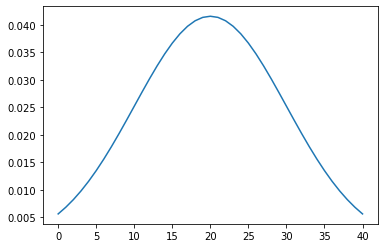

In [13]:
filtwidth = 10
t = np.linspace(-2 * filtwidth, 2 * filtwidth, 4 * filtwidth + 1)
h = np.exp(-t ** 2 / (2 * filtwidth ** 2))
h = h / np.sum(h)
plt.plot(h)

In [14]:
def spike_smooth(x,trials_idx,filt = h):
    sm_x = np.zeros(x.shape[0])
    for tr in np.unique(trials_idx):
        sel = trials_idx == tr
        sm_x[sel] = convolve1d(x[sel],filt,mode='nearest')
    return sm_x

def pop_spike_convolve(spike_mat,trials_idx,filt = h):
    sm_spk = np.zeros(spike_mat.shape)
    for neu in range(spike_mat.shape[1]):
        sm_spk[:,neu] = spike_smooth(spike_mat[:,neu],trials_idx,filt)
    return sm_spk

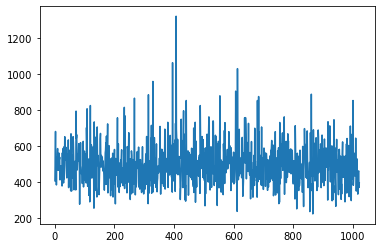

In [16]:
num_points = np.empty(len(trial_keep))
for i,tr in enumerate(trial_keep):
    num_points[i] = len(yt[trial_idx == tr][:, 0])
plt.plot(num_points)

In [17]:
# event_list = ['t_targ', 't_stop', 't_reward']
event_list = ['t_flyOFF', 't_stop', 't_reward']

In [18]:
flyON_dur = 50 # number of time points

In [19]:
def compute_median_IEI(X,varnames,event_list,trial_idx,dt=0.006#,flyON_dur=50
                      ):
    """
    IEI = inter event interval
    ES = event starts
    EE = event ends
    flyON_dur = duration of target on in time points (50 tp correspond 50*dt sec, in 6ms bins it is 300ms)
    :return:
    """
    tr_with_event = {}
    tr_without_event = {}
    event_dict = {}
    for event in event_list:
        event_dict[event] = event
        tr_with_event[event_dict[event]] = []
        tr_without_event[event_dict[event]] = []

        event_col = np.where(varnames == event_dict[event])[0][0]
        for tr in np.unique(trial_idx):
            if any(X[trial_idx == tr, event_col]):
                tr_with_event[event_dict[event]] += [tr]
            else:
                tr_without_event[event_dict[event]] += [tr]
        tr_with_event[event_dict[event]] = set(tr_with_event[event_dict[event]])

    median_iei = np.zeros(len(event_list) - 1)
    for k in range(len(event_list) - 1):
        ev1 = event_list[k]
        ev2 = event_list[k+1]
        ev1_col = np.where(varnames == ev1)[0][0]
        ev2_col = np.where(varnames == ev2)[0][0]
        trial_use = np.sort(list(tr_with_event[ev1].intersection(tr_with_event[ev2])))
        # Julie changed here to only include successful trials:
        trial_use = np.intersect1d(trial_use, np.array(list(tr_with_event['t_reward'])))
        
        iei = np.zeros(trial_use.shape[0])
        cc = 0
#         if ev1 == 't_targ':
        if ev1 == 't_flyOFF':
            es = np.zeros(trial_use.shape[0])
            for tr in trial_use:
                iei[cc] = (np.where(X[trial_idx==tr, ev2_col])[0][0] - np.where(X[trial_idx==tr, ev1_col])[0][0])*dt + flyON_dur*dt
                es[cc] = np.where(X[trial_idx==tr, ev1_col])[0][0] - flyON_dur
                cc += 1
        elif ev2 == 't_reward':
            ee = np.zeros(trial_use.shape[0])
            for tr in trial_use:
                iei[cc] = (np.where(X[trial_idx==tr, ev2_col])[0][0] - np.where(X[trial_idx==tr, ev1_col])[0][0])*dt
                ee[cc] = len(np.where(trial_idx == tr)[0]) - np.where(X[trial_idx==tr, ev2_col])[0][0]
                cc += 1            
        else:
            for tr in trial_use:
                iei[cc] = (np.where(X[trial_idx==tr, ev2_col])[0][0] - np.where(X[trial_idx==tr, ev1_col])[0][0])*dt
                cc += 1


        median_iei[k] = np.median(iei)
    
    es = np.median(es)*dt
    ee = np.median(ee)*dt
    return median_iei,tr_without_event,es,ee

In [20]:
def compute_aligned_rate(spk_mat, X, varnames, h, trial_idx, event_align,dt=0.006,# flyON_dur=50,
                         num_tp_x_bin=None,
                         pre_trial_dur=pre_trial_dur, post_trial_dur=post_trial_dur):
    # this code implies that reward is the last event
    assert(event_align[-1] == 't_reward')
    # get median iei
    median_iei_middle, tr_without_event, es, ee = compute_median_IEI(X,varnames,event_align,trial_idx,dt=dt) #,flyON_dur=flyON_dur)
    
    # Julie: include pre-trial and post-trial points here, this is the unified time length
    median_iei = np.zeros(len(median_iei_middle) + 2)
    median_iei[0] = es # The unit should be in seconds
    median_iei[1:-1] = median_iei_middle
    median_iei[-1] = ee

    # set time points number for aligned trials

    num_tp = 0
    if num_tp_x_bin is None:
        num_tp_x_bin = []
        time_bounds = np.cumsum(np.hstack(([0],median_iei)))
        for k in range(median_iei.shape[0]):
            t0 = time_bounds[k]
            t1 = time_bounds[k+1]
            num_tp_x_bin += [int(np.ceil((t1 - t0) / dt))]
            num_tp += num_tp_x_bin[-1] - 1


    else:
        time_bounds = np.cumsum(np.hstack(([0], median_iei)))
        for k in range(median_iei.shape[0]):
            num_tp += num_tp_x_bin[k] - 1


    # extract firing rate estimate
    firing_rate_est = pop_spike_convolve(spk_mat, trial_idx, h)/dt

    # Julie changed here - but it's bad practice!
    unq_trials = np.array(list(set(np.unique(trial_idx)) - set(tr_without_event['t_reward'])))
    trial_rescaled_rate = np.zeros((spk_mat.shape[1],unq_trials.shape[0], num_tp)) * np.nan
    rescaled_vel = np.zeros((unq_trials.shape[0], num_tp)) * np.nan
    rescaled_ang = np.zeros((unq_trials.shape[0], num_tp)) * np.nan
    rescaled_ev = np.zeros((unq_trials.shape[0], num_tp)) * np.nan
    rescaled_eh = np.zeros((unq_trials.shape[0], num_tp)) * np.nan
#     rescaled_rd_1 = np.zeros((unq_trials.shape[0], num_tp)) * np.nan
#     rescaled_ad_1 = np.zeros((unq_trials.shape[0], num_tp)) * np.nan
#     rescaled_rd_2 = np.zeros((unq_trials.shape[0], num_tp)) * np.nan
#     rescaled_ad_2 = np.zeros((unq_trials.shape[0], num_tp)) * np.nan
    rescaled_rd = np.zeros((unq_trials.shape[0], num_tp)) * np.nan
    rescaled_ad = np.zeros((unq_trials.shape[0], num_tp)) * np.nan
    rescaled_ra = np.zeros((unq_trials.shape[0], num_tp)) * np.nan 
    rescaled_aa = np.zeros((unq_trials.shape[0], num_tp)) * np.nan 


#     timeSTOP = np.zeros((unq_trials.shape[0])) * np.nan
#     timeSTART = np.zeros((unq_trials.shape[0])) * np.nan
#     timeOFF = np.zeros((unq_trials.shape[0])) * np.nan
    isREW = np.zeros((unq_trials.shape[0]),dtype=bool)
# For recording the initial distance to target, maybe useful later
#     rad_targ_vec = np.zeros(unq_trials.shape[0])
    cnt_tr = 0
    trial_list = []
    for tr in unq_trials:
        if cnt_tr % 100 == 0:
            print('%d/%d'%(cnt_tr+1,unq_trials.shape[0]))
        skip_trial = False
        is_rew = not (tr in tr_without_event['t_reward'])
        rad_vel = X[trial_idx == tr, np.where(varnames == 'rad_vel')].reshape(-1)
        ang_vel = X[trial_idx == tr, np.where(varnames == 'ang_vel')].reshape(-1)
        eye_vert = X[trial_idx == tr, np.where(varnames == 'eye_vert')].reshape(-1)
        eye_hori = X[trial_idx == tr, np.where(varnames == 'eye_hori')].reshape(-1)

#         rad_targ_1 = X[trial_idx == tr, np.where(varnames == 'rad_target_1')].reshape(-1)
#         ang_targ_1 = X[trial_idx == tr, np.where(varnames == 'ang_target_1')].reshape(-1)
#         rad_targ_2 = X[trial_idx == tr, np.where(varnames == 'rad_target_2')].reshape(-1)
#         ang_targ_2 = X[trial_idx == tr, np.where(varnames == 'ang_target_2')].reshape(-1)
        rad_targ = X[trial_idx == tr, np.where(varnames == 'rad_target')].reshape(-1)
        ang_targ = X[trial_idx == tr, np.where(varnames == 'ang_target')].reshape(-1)
        rad_acc = X[trial_idx == tr, np.where(varnames == 'rad_acc')].reshape(-1)
        ang_acc = X[trial_idx == tr, np.where(varnames == 'ang_acc')].reshape(-1)


#         try:
#             rad_targ_vec[cnt_tr] = rad_targ[~np.isnan(rad_targ)][0]
#         except:
#             rad_targ_vec[cnt_tr] = np.nan
        if tr == unq_trials[0]:
            time_rescale_all = []
        cc = 0
        trial_list += [tr]
        
        
        # Having reward and non-reward trials makes things complicated...
        # this considers reward as last event
        
        ev0 = event_align[-2]
        tp_last = np.where(X[trial_idx==tr, np.where(varnames==ev0)] == 1)[1][0]
        if ~is_rew:
            sele_tr = np.where(trial_idx == tr)[0]
            sele_tr = sele_tr[tp_last:-int(np.ceil(post_trial_dur / dt))]
            tp_reward = tp_last + min(int(median_iei[-2] / dt), sele_tr.shape[0])
        else:
            tp_reward = np.where(X[trial_idx==tr, np.where(varnames=='t_reward')] == 1)[1][0]
        for k in range(median_iei.shape[0]):
            # This is specific to trials
            time_points = num_tp_x_bin[k]

            if k == 0:
                tp_0 = 0
                try:
#                     tp_1 = np.where(X[trial_idx==tr, np.where(varnames=='t_targ')] == 1)[1][0]
                    tp_1 = np.where(X[trial_idx==tr, np.where(varnames=='t_flyOFF')] == 1)[1][0]

                except:
                    print('skip tr',cnt_tr)
                    rescaled_vel[cnt_tr, cc:cc + time_points - 1] = np.nan
                    rescaled_ang[cnt_tr, cc:cc + time_points - 1] = np.nan
                    rescaled_ev[cnt_tr, cc:cc + time_points - 1] = np.nan
                    rescaled_eh[cnt_tr, cc:cc + time_points - 1] = np.nan
#                     rescaled_ad_1[cnt_tr, cc:cc + time_points - 1] = np.nan
#                     rescaled_rd_1[cnt_tr, cc:cc + time_points - 1] = np.nan
#                     rescaled_ad_2[cnt_tr, cc:cc + time_points - 1] = np.nan
#                     rescaled_rd_2[cnt_tr, cc:cc + time_points - 1] = np.nan
                    rescaled_ad[cnt_tr, cc:cc + time_points - 1] = np.nan
                    rescaled_rd[cnt_tr, cc:cc + time_points - 1] = np.nan
                    rescaled_ra[cnt_tr, cc:cc + time_points - 1] = np.nan
                    rescaled_aa[cnt_tr, cc:cc + time_points - 1] = np.nan


                    cc += (time_points - 1)
                    continue
            elif k == median_iei.shape[0] - 1:
                tp_0 = tp_reward
                tp_1 = len(np.where(trial_idx==tr)[0])-1
            else:            
                ev1 = event_align[k-1]
                ev2 = event_align[k]
                try:
                    tp_0 = np.where(X[trial_idx==tr, np.where(varnames==ev1)] == 1)[1][0]
                except:
                    print('skip tr',cnt_tr)
                    rescaled_vel[cnt_tr, cc:cc + time_points - 1] = np.nan
                    rescaled_ang[cnt_tr, cc:cc + time_points - 1] = np.nan
                    rescaled_ev[cnt_tr, cc:cc + time_points - 1] = np.nan
                    rescaled_eh[cnt_tr, cc:cc + time_points - 1] = np.nan
#                     rescaled_ad_1[cnt_tr, cc:cc + time_points - 1] = np.nan
#                     rescaled_rd_1[cnt_tr, cc:cc + time_points - 1] = np.nan
#                     rescaled_ad_2[cnt_tr, cc:cc + time_points - 1] = np.nan
#                     rescaled_rd_2[cnt_tr, cc:cc + time_points - 1] = np.nan
                    rescaled_ad[cnt_tr, cc:cc + time_points - 1] = np.nan
                    rescaled_rd[cnt_tr, cc:cc + time_points - 1] = np.nan
                    rescaled_aa[cnt_tr, cc:cc + time_points - 1] = np.nan
                    rescaled_ra[cnt_tr, cc:cc + time_points - 1] = np.nan
                    cc += (time_points - 1)
                    continue

                tp_0 = np.where(X[trial_idx==tr, np.where(varnames==ev1)] == 1)[1][0]
                if ev2 == 't_reward':
                    tp_1 = tp_reward
                else:
                    tp_1 = np.where(X[trial_idx==tr, np.where(varnames==ev2)] == 1)[1][0]



            if tp_0 >= tp_1-1:
                skip_trial = True
                break




            time_rescale = np.linspace(time_bounds[k], time_bounds[k+1], time_points)[:-1]

            if tr == unq_trials[0]:
                time_rescale_all = np.hstack((time_rescale_all,time_rescale))


            rates = firing_rate_est[trial_idx == tr,:]
            rates = rates[tp_0: tp_1, :]
            rad_vel_tmp = rad_vel[tp_0:tp_1]
            ang_vel_tmp = ang_vel[tp_0:tp_1]
            eye_hori_tmp = eye_hori[tp_0:tp_1]
            eye_vert_tmp = eye_vert[tp_0:tp_1]
#             rad_targ_tmp_1 = rad_targ_1[tp_0:tp_1]
#             ang_targ_tmp_1 = ang_targ_1[tp_0:tp_1]
#             rad_targ_tmp_2 = rad_targ_2[tp_0:tp_1]
#             ang_targ_tmp_2 = ang_targ_2[tp_0:tp_1]
            rad_targ_tmp = rad_targ[tp_0:tp_1]
            ang_targ_tmp = ang_targ[tp_0:tp_1]
            rad_acc_tmp = rad_acc[tp_0:tp_1]
            ang_acc_tmp = ang_acc[tp_0:tp_1]

            time_tr = np.linspace(time_rescale[0], time_rescale[-1], rates.shape[0])
            
            
            interp_vel = interp1d(time_tr, rad_vel_tmp, kind='linear')
            interp_ang = interp1d(time_tr, ang_vel_tmp, kind='linear')
            interp_ev = interp1d(time_tr, eye_vert_tmp, kind='linear')
            interp_eh = interp1d(time_tr, eye_hori_tmp, kind='linear')
#             interp_ad_1 = interp1d(time_tr, ang_targ_tmp_1, kind='linear')
#             interp_rd_1 = interp1d(time_tr, rad_targ_tmp_1, kind='linear')
#             interp_ad_2 = interp1d(time_tr, ang_targ_tmp_2, kind='linear')
#             interp_rd_2 = interp1d(time_tr, rad_targ_tmp_2, kind='linear')
            interp_ad = interp1d(time_tr, ang_targ_tmp, kind='linear')
            interp_rd = interp1d(time_tr, rad_targ_tmp, kind='linear')
            interp_aa = interp1d(time_tr, ang_acc_tmp, kind='linear')
            interp_ra = interp1d(time_tr, rad_acc_tmp, kind='linear')


            rescaled_vel[cnt_tr,cc:cc+time_points-1] = interp_vel(time_rescale)
            rescaled_ang[cnt_tr,cc:cc+time_points-1] = interp_ang(time_rescale)
            rescaled_ev[cnt_tr,cc:cc+time_points-1] = interp_ev(time_rescale)
            rescaled_eh[cnt_tr,cc:cc+time_points-1] = interp_eh(time_rescale)
#             rescaled_ad_1[cnt_tr,cc:cc+time_points-1] = interp_ad_1(time_rescale)
#             rescaled_rd_1[cnt_tr,cc:cc+time_points-1] = interp_rd_1(time_rescale)
#             rescaled_ad_2[cnt_tr,cc:cc+time_points-1] = interp_ad_2(time_rescale)
#             rescaled_rd_2[cnt_tr,cc:cc+time_points-1] = interp_rd_2(time_rescale)
            rescaled_ad[cnt_tr,cc:cc+time_points-1] = interp_ad(time_rescale)
            rescaled_rd[cnt_tr,cc:cc+time_points-1] = interp_rd(time_rescale)
            rescaled_aa[cnt_tr,cc:cc+time_points-1] = interp_aa(time_rescale)
            rescaled_ra[cnt_tr,cc:cc+time_points-1] = interp_ra(time_rescale)





            for neu in range(rates.shape[1]):
                interp = interp1d(time_tr, rates[:,neu], kind='linear')
                trial_rescaled_rate[neu, cnt_tr, cc:cc+time_points-1] = interp(time_rescale)

            cc += (time_points-1)
            
                    
        # Correct for NaNs
#         rd_1 = rescaled_rd_1[cnt_tr]
#         rd_1[np.isnan(rd_1)] = np.median(rd_1[~np.isnan(rd_1)])        
#         rescaled_rd_1[cnt_tr] = rd_1
#         rd_2 = rescaled_rd_2[cnt_tr]
#         rd_2[np.isnan(rd_2)] = np.median(rd_2[~np.isnan(rd_2)])        
#         rescaled_rd_2[cnt_tr] = rd_2
        rd = rescaled_rd[cnt_tr]
        rd[np.isnan(rd)] = np.median(rd[~np.isnan(rd)])        
        rescaled_rd[cnt_tr] = rd
        
        vel = rescaled_vel[cnt_tr]
        vel[np.isnan(vel)] = np.median(vel[~np.isnan(vel)])        
        rescaled_vel[cnt_tr] = vel
        
        ra = rescaled_ra[cnt_tr]
        ra[np.isnan(ra)] = np.median(ra[~np.isnan(ra)])        
        rescaled_ra[cnt_tr] = ra       
        
        
        # Julie: this seems necessary
        for neu in range(rates.shape[1]):
            rt = trial_rescaled_rate[neu, cnt_tr]
#             rt[np.isnan(rt)] = np.median(rt[~np.isnan(rt)])
            rt[np.isnan(rt)] = 0
            trial_rescaled_rate[neu, cnt_tr] = rt


        isREW[cnt_tr] = is_rew
        cnt_tr += 1

    return (np.array(time_rescale_all), time_bounds, trial_rescaled_rate,num_tp_x_bin,
            np.array(trial_list),# rad_targ_vec,
            rescaled_vel,# timeOFF,timeSTART,timeSTOP,
            isREW,rescaled_ang,rescaled_ev,rescaled_eh,rescaled_ad,rescaled_rd,rescaled_ra,rescaled_aa,tr_without_event)
# ,rescaled_ad_2,rescaled_rd_2)


In [21]:
(time_rescale_all,time_bounds, trial_rescaled_rate,num_timept_x_bin,trial_list,#rad_targ_vec,
 rescaled_vel,# timeOFF,timeSTART,timeSTOP,
 isREW,rescaled_ang,rescaled_ev,rescaled_eh,rescaled_ad,rescaled_rd,rescaled_ra,rescaled_aa, tr_without_event) =\
compute_aligned_rate(yt, Xt, var_names, h, trial_idx, event_list,dt=0.006,# flyON_dur=50,
                     num_tp_x_bin=None)

1/584
101/584
201/584
301/584
401/584
501/584


In [23]:
# Discard the junk trials
# This is desperate..should change later!!
# trial_rescaled_rate = trial_rescaled_rate[:,1:,:]
# rescaled_rd_1 = rescaled_rd_1[1:]
# rescaled_rd_2 = rescaled_rd_2[1:]
# trial_keep = np.delete(trial_keep, 0)

In [22]:
num_timept_x_bin

[67, 256, 74, 96]

In [23]:
np.shape(trial_rescaled_rate)

(68, 584, 489)

In [26]:
decoder_time = np.arange(30, int(np.ceil(np.shape(trial_rescaled_rate)[2]/10)*10), 10)
print(decoder_time)

[ 30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180 190 200
 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380
 390 400 410 420 430 440 450 460 470 480]


In [27]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, train_test_split
import sklearn.metrics as metrics
import pandas as pd

def test(model, dataX, dataY, iterations = 100):
    r2_train = []
    r2_test = []
    for j in range(iterations):
        X_train, X_test, y_train, y_test = train_test_split(dataX, 
                                                            dataY, 
                                                            test_size= 0.2)
        r2_test.append(metrics.r2_score(y_test,
                                        model.fit(X_train, 
                                                     y_train).predict(X_test)))
        r2_train.append(metrics.r2_score(y_train, 
                                         model.fit(X_train, 
                                                      y_train).predict(X_train)))
    return [np.mean(r2_train), np.mean(r2_test)]

In [28]:
from sklearn.model_selection import cross_val_score
# function to get cross validation scores
def get_cv_scores(model, x_train, y_train):
    scores = cross_val_score(model.fit(x_train, y_train),
                             x_train,
                             y_train,
                             cv=5,
                             scoring='r2')
    
#     print('CV Mean: ', np.mean(scores))
#     print('STD: ', np.std(scores))
#     print('\n')
    return np.mean(scores)

In [29]:
lasso_params = {'alpha':np.linspace(60.0, 80.0, 10)}

model_1 = []
model_2 = []
results_1 = np.empty((len(decoder_time), 2)) # 2 is for train and test dataset
results_2 = np.empty((len(decoder_time), 2)) # 2 is for train and test dataset


for i,time in enumerate(decoder_time-1):
    grid_1 = GridSearchCV(linear_model.Lasso(), param_grid=lasso_params).\
    fit(trial_rescaled_rate[neuron_keep - 1,:,time].T, rescaled_rd[:,time])
    model_1.append(grid_1.best_estimator_)

    
#     grid_2 = GridSearchCV(linear_model.Lasso(), param_grid=lasso_params).\
#     fit(trial_rescaled_rate[neuron_keep - 1,:,time].T, rescaled_rd_2[:,time])
#     model_2.append(grid_2.best_estimator_)
#     get_cv_scores(model_2[i], fit_x[:,:,i], fit_y_2[:,i])
#     print(grid_2.best_params_)
    
    results_1[i] = test(model_1[i], trial_rescaled_rate[neuron_keep - 1,:,time].T, rescaled_rd[:,time])
#     results_2[i] = test(model_2[i], trial_rescaled_rate[neuron_keep - 1,:,time].T, rescaled_rd_2[:,time])

[ 3.7 29.3 36.7 46.3]


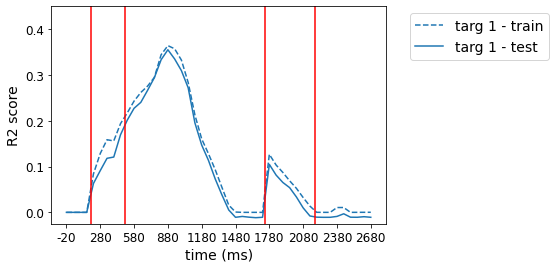

In [30]:
dt = 6
pre_trial_dur = 200

results_1[:int((np.cumsum(num_timept_x_bin)[0]-decoder_time[0])/10)+1] = 0

plt.plot(results_1[:, 0], '--', color='tab:blue', label='targ 1 - train')
plt.plot(results_1[:, 1], color='tab:blue', label='targ 1 - test')
# plt.plot(results_2[:, 0], '--', color='tab:orange', label='targ 2 - train')
# plt.plot(results_2[:, 1], color='tab:orange', label='targ2 - test')
idx = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
labels = decoder_time[idx] * dt - pre_trial_dur
plt.xticks(idx, labels, fontsize=12)
plt.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('time (ms)', fontsize=14)
plt.ylabel('R2 score', fontsize=14) # coefficient of determination
plt.ylim([-0.025, 0.45])
plt.yticks(fontsize=12)
markers = (np.cumsum(num_timept_x_bin) - decoder_time[0])/10
for i in range(len(markers)-1):    
    plt.axvline(x=markers[i], c='r')
plt.axvline(x=markers[0] + 5, c='r') # target ON
print(markers)